In [2]:
# First clone the repository so we have access to the data
!git clone https://github.com/srpraveen97/LSTM_nonlinear.git

Cloning into 'LSTM_nonlinear'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 89 (delta 0), reused 0 (delta 0), pack-reused 88
Receiving objects: 100% (89/89), 1.69 MiB | 9.30 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [3]:
%cd /content/LSTM_nonlinear/

/content/LSTM_nonlinear


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn

import seaborn as sns
sns.set()

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18,12)
mpl.rcParams['axes.grid'] = False
sns.set_style('whitegrid')

from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from pickle import load

In [5]:
# Upload the data frame into the notebook
data_frame = pd.read_csv('Data/RNN_MPC_data.csv')

In [6]:
data_frame.head()

,Ca,Tr,Ca0,Q
0,1.000000,300.000000,3.419154,61.201253
1,1.198907,310.266894,0.500801,-54.907623
2,1.132610,301.652314,1.527291,-113.239288
3,1.146201,283.779092,1.803821,-42.899801
4,1.173853,278.641640,3.277372,10.782427


In [8]:
data_frame.shape

(1515, 4)

<Axes: >

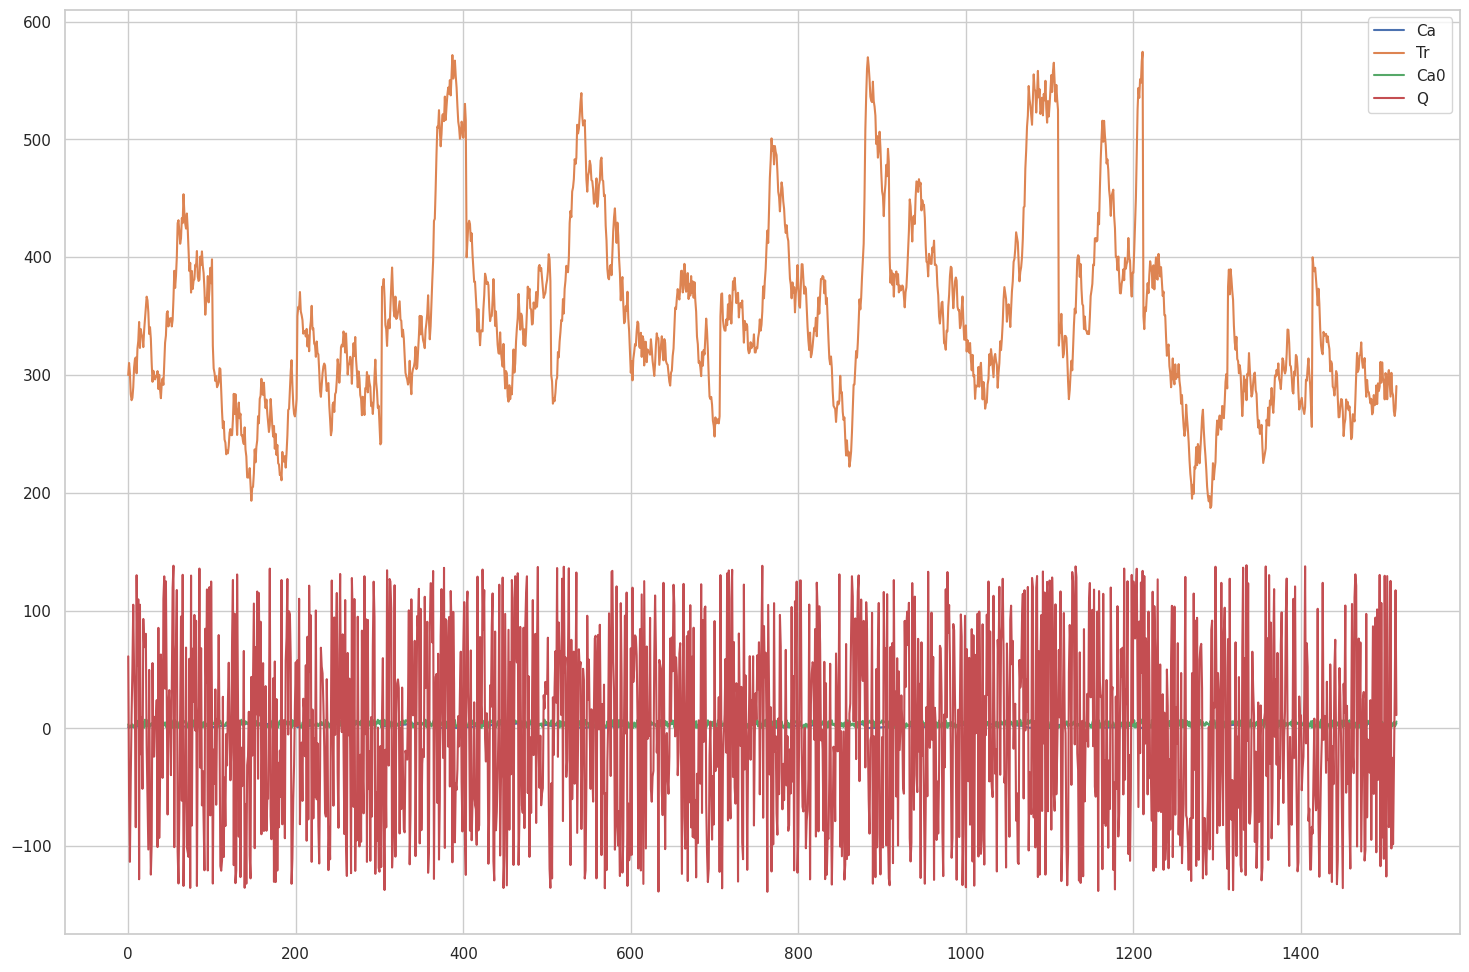

In [6]:
data_frame.plot()

In [27]:
# Defining a batch size based on the data
batch_size = 101

# Split the dataset into different batches
batch_data = np.array_split(data_frame,int(data_frame.shape[0]/batch_size))

# Shifting batch number 5 to the end to be used as a test data
batch_data.append(batch_data.pop(5))

# Combining all the batches to form a single dataset
df = pd.DataFrame(np.concatenate(batch_data), columns=list(data_frame.columns))

In [50]:
# x1 -> Ca
# x2 -> Tr
# u1 -> Ca0
# u2 -> Q
df

,Ca,Tr,Ca0,Q
0,1.000000,300.000000,3.419154,61.201253
1,1.198907,310.266894,0.500801,-54.907623
2,1.132610,301.652314,1.527291,-113.239288
3,1.146201,283.779092,1.803821,-42.899801
4,1.173853,278.641640,3.277372,10.782427
...,...,...,...,...
1510,2.538290,311.873024,3.689816,-107.358443
1511,2.576682,295.497232,2.007266,119.512025
1512,2.422988,313.784878,0.555263,39.408847
1513,2.500509,319.367203,5.012638,50.069804


In [33]:
batch_data = np.array(batch_data)

In [34]:
batch_data.shape

(15, 101, 4)

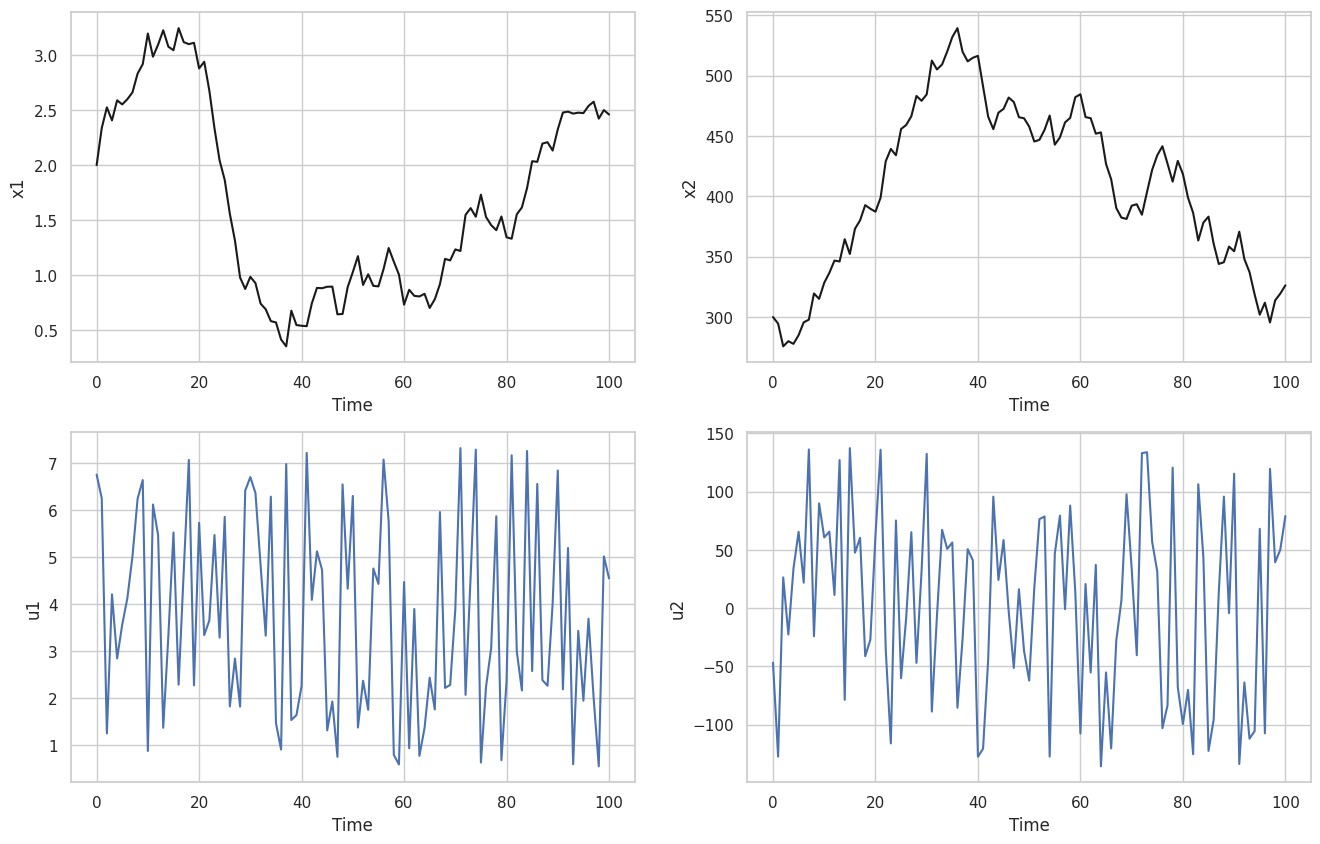

In [35]:
# Plotting the test data batch
fig = plt.figure(figsize=(16,10))

batch_no = 15

plt.subplot(2, 2, 1)
plt.plot(batch_data[batch_no-1,:,0],'k')
plt.xlabel('Time')
plt.ylabel('x1')

plt.subplot(2, 2, 2)
plt.plot(batch_data[batch_no-1,:,1],'k')
plt.xlabel('Time')
plt.ylabel('x2')

plt.subplot(2, 2, 3)
plt.plot(batch_data[batch_no-1,:,2],'b')
plt.xlabel('Time')
plt.ylabel('u1')

plt.subplot(2, 2, 4)
plt.plot(batch_data[batch_no-1,:,3],'b')
plt.xlabel('Time')
plt.ylabel('u2')

plt.show()

In [36]:
# Define a test size
test_size = batch_size

y = df.values.astype(float)

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [37]:
# Scaling the training and testing data
scaler1 = MinMaxScaler(feature_range=(-1, 1))
scaler2 = MinMaxScaler(feature_range=(-1, 1))

# Fitting a scaler for states and inputs seperately
train_norm_states = scaler1.fit_transform(train_set[:,:2].reshape(-1,2))
train_norm_inputs = scaler2.fit_transform(train_set[:,2:].reshape(-1,2))

train_norm = np.hstack((train_norm_states, train_norm_inputs))

test_norm_states = scaler1.transform(test_set[:,:2].reshape(-1,2))
test_norm_inputs = scaler2.transform(test_set[:,2:].reshape(-1,2))

test_norm = np.hstack((test_norm_states, test_norm_inputs))

# Saving the scalers as pickle objects to be used for testing
dump(scaler1, open('Models/scaler1.pkl', 'wb'))
dump(scaler2, open('Models/scaler2.pkl', 'wb'))

In [38]:
# Convert train set into a torch tensor
train_set_norm = torch.FloatTensor(train_norm).view(-1,df.shape[1])
test_set_norm = torch.FloatTensor(test_norm).view(-1,df.shape[1])

In [49]:
train_set_norm

tensor([[-0.6989, -0.4173, -0.1654,  0.4420],
        [-0.6087, -0.3643, -0.9998, -0.3957],
        [-0.6388, -0.4088, -0.7063, -0.8165],
        ...,
        [ 0.7119, -0.5968, -0.6827,  0.2069],
        [ 0.6576, -0.5632, -0.3753,  0.8465],
        [ 0.6894, -0.4655,  0.5395,  0.0823]])

In [39]:
# Creating a function to generate the input data for the lstm
def input_data(seq,ws):

    inp_data = []

    for bat in range(0,train_set.shape[0],batch_size):

        bat_seq = seq[bat:bat+batch_size]
        l = len(bat_seq)

        window = []
        label = []

        for i in range(l-ws):

            window = bat_seq[i:i+ws]
            label = bat_seq[i+ws:i+ws+1,:2] # The one here represents the future window

            inp_data.append((window,label))

    return inp_data

In [40]:
# Defining a window size for prediction
window_size = 1
train_data = input_data(train_set_norm,window_size)

In [48]:
train_data[0]

(tensor([[-0.6989, -0.4173, -0.1654,  0.4420]]), tensor([[-0.6087, -0.3643]]))

In [ ]:
# Defining the LSTM model with two hidden layers
class LSTMmodel(nn.Module):

    def __init__(self,input_size,hidden_size_1,hidden_size_2,out_size):

        super().__init__()

        self.hidden_size_1 = hidden_size_1

        self.hidden_size_2 = hidden_size_2

        self.input_size = input_size

        self.lstm_1 = nn.LSTM(input_size,hidden_size_1)

        self.lstm_2 = nn.LSTM(hidden_size_1,hidden_size_2)

        self.linear = nn.Linear(hidden_size_2,out_size)

        self.hidden_1 = (torch.zeros(1,1,hidden_size_1), torch.zeros(1,1,hidden_size_1))

        self.hidden_2 = (torch.zeros(1,1,hidden_size_2), torch.zeros(1,1,hidden_size_2))

    def forward(self,seq):

        lstm_out_1 , self.hidden_1 = self.lstm_1(seq.view(-1,1,self.input_size),self.hidden_1)

        lstm_out_2 , self.hidden_2 = self.lstm_2(lstm_out_1,self.hidden_2)

        pred = self.linear(lstm_out_2.view(len(seq),-1))

        return pred

In [ ]:
# Creating a model instance, loss function and the optimizer
model = LSTMmodel(input_size=4,hidden_size_1=15,hidden_size_2=10,out_size=2)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
display(model)

LSTMmodel(
  (lstm_1): LSTM(4, 15)
  (lstm_2): LSTM(15, 10)
  (linear): Linear(in_features=10, out_features=2, bias=True)
)

In [ ]:
display(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

   240
   900
    60
    60
   600
   400
    40
    40
    20
     2
______
  2362


In [ ]:
# Set the number of epochs

epochs = 100

for epoch in range(epochs):

    # Running each batch separately

    for bat in range(0,1400,100):

        for seq,label in train_data[bat:bat+100]:

            # set the optimization gradient to zero

            optimizer.zero_grad()

            # initialize the hidden states

            model.hidden_1 = (torch.zeros(1,1,model.hidden_size_1),
                            torch.zeros(1,1,model.hidden_size_1))

            model.hidden_2 = (torch.zeros(1,1,model.hidden_size_2),
                            torch.zeros(1,1,model.hidden_size_2))

            # Make predictions on the current sequence

            y_pred = model(seq)

            # Compute the loss

            loss = criterion(y_pred, label)

            # Perform back propogation and gradient descent

            loss.backward()

            optimizer.step()

    if epoch%10 == 0:

        print(f'Epoch: {epoch} Loss: {loss.item():10.8f}')

Epoch: 0 Loss: 0.00019266
Epoch: 10 Loss: 0.00029507
Epoch: 20 Loss: 0.00039715
Epoch: 30 Loss: 0.00044336
Epoch: 40 Loss: 0.00060252
Epoch: 50 Loss: 0.00070656
Epoch: 60 Loss: 0.00076211
Epoch: 70 Loss: 0.00079265
Epoch: 80 Loss: 0.00081075
Epoch: 90 Loss: 0.00081914


In [ ]:
future = 100

# Set the model to evaluation mode

model.eval()

preds = [test_set_norm[0,:2].reshape(-1,2)]

for i in range(future):

    seq = test_set_norm[i].reshape(-1,4)

    # Informing PyTorch that I am no longer interested in the gradients

    with torch.no_grad():

        # Initialize the hidden states

        model.hidden_1 = (torch.zeros(1,1,model.hidden_size_1),
                        torch.zeros(1,1,model.hidden_size_1))
        model.hidden_2 = (torch.zeros(1,1,model.hidden_size_2),
                        torch.zeros(1,1,model.hidden_size_2))
        preds.append(model(seq))

In [ ]:
predictions = scaler1.inverse_transform(np.array([pred.numpy() for pred in preds]).reshape(-1,2))

true_values = test_set[:,:2]

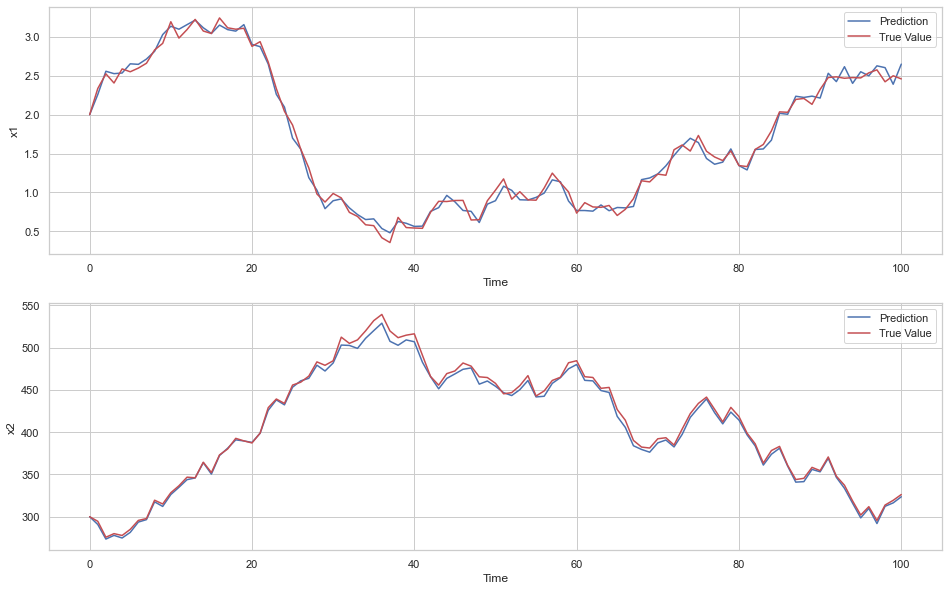

In [ ]:
# Plotting the testing batch
fig = plt.figure(figsize=(16,10))

plt.subplot(2, 1, 1)
plt.plot(predictions[:,0],'b',label='Prediction')
plt.plot(true_values[:,0],'r',label='True Value')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x1')

plt.subplot(2, 1, 2)
plt.plot(predictions[:,1],'b',label='Prediction')
plt.plot(true_values[:,1],'r',label='True Value')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x2');

In [ ]:
RMSE = np.sqrt(np.sum(np.square((predictions - true_values)))/202)
display(RMSE)

3.276292564748718

In [ ]:
# Saving the model for future use
torch.save(model.state_dict(), 'Models/LSTM_CSTR_model')

In [ ]:
future = 100

# Set the model to evaluation mode

model.eval()

preds = [test_set_norm[0,:2].reshape(-1,2)]

for i in range(future):

    seq = torch.cat((preds[i],test_set_norm[i,2:4].view(1,-1))).view(-1,4)

    # Informing PyTorch that I am no longer interested in the gradients

    with torch.no_grad():

        # Initialize the hidden states

        model.hidden_1 = (torch.zeros(1,1,model.hidden_size_1),
                        torch.zeros(1,1,model.hidden_size_1))
        model.hidden_2 = (torch.zeros(1,1,model.hidden_size_2),
                        torch.zeros(1,1,model.hidden_size_2))
        preds.append(model(seq))

In [ ]:
predictions = scaler1.inverse_transform(np.array([pred.numpy() for pred in preds]).reshape(-1,2))

true_values = test_set[:future+1,:2]

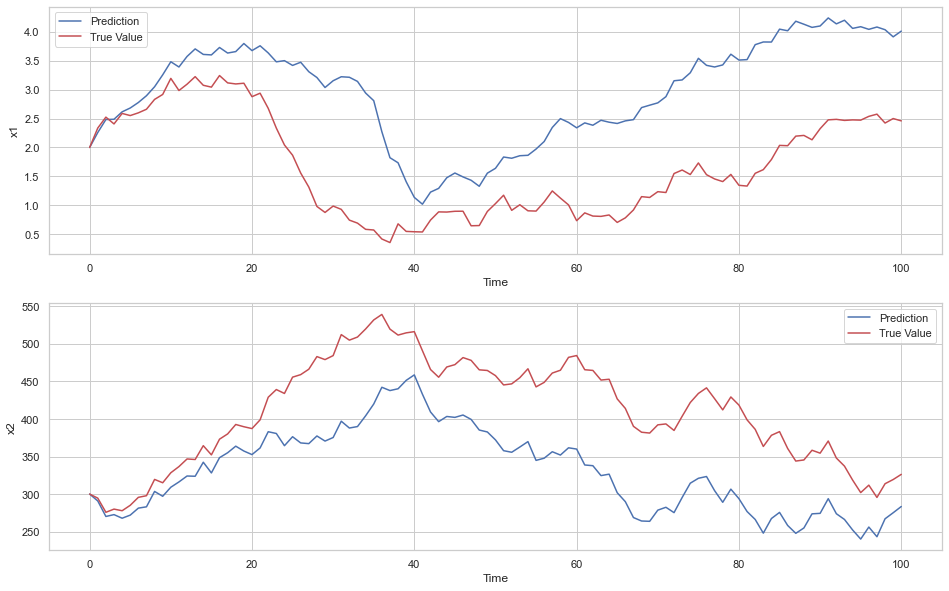

In [ ]:
# Plotting the testing batch
fig = plt.figure(figsize=(16,10))

plt.subplot(2, 1, 1)
plt.plot(predictions[:,0],'b',label='Prediction')
plt.plot(true_values[:,0],'r',label='True Value')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x1')

plt.subplot(2, 1, 2)
plt.plot(predictions[:,1],'b',label='Prediction')
plt.plot(true_values[:,1],'r',label='True Value')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x2');